In [1]:
!pip install pytorch-lightning
!pip install torch-summary

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.6/774.6 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 64.2 MB/s eta 0:00:00


In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from pytorch_lightning import loggers as pl_loggers
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import torchmetrics

<a href="https://imgflip.com/i/81780o"><img src="https://i.imgflip.com/81780o.jpg" title="made at imgflip.com"/></div>

# Pytorch-Lightning : Training made Easier

Time : 4 hours

In the Tutorial session, we used PyTorch to train different models for Binary Classification. In the tutorial, few things were done :


*   We created a Training/Testing Loop and trained our models
*   We created a Trainer Class to gather all loops to perform the Training/Testing.


As you have seen, writing the training and testing loop can be quickly indigest. One can get easily lost.

Let us introduce you Pytorch Lightning

<img src="https://pypi-camo.global.ssl.fastly.net/8bfd70b3d9aaf6804f26582374e201ecfff288fe/68747470733a2f2f706c2d7075626c69632d646174612e73332e616d617a6f6e6177732e636f6d2f6173736574735f6c696768746e696e672f7079746f7263682d6c696768746e696e672e706e67">


Pytorch lightning will handle a lot of things for you. It creates a Trainer which is a Code Management trick used by many companies (Meta, Google..) in order to get much more digest code.


More Information on : https://www.pytorchlightning.ai/

Goal of this lab :

* Use Pytorch Lightning for Training
* Learn to use Pytorch-Lightning
* Do classification on FashionMNIST, CIFAR-10


# I - Classify Clothes using Lightning


In this part, we will classify clothes.
We will use the Lightning framework for code management. What's interesting about Lightning is that you can plug in your Torch modules without any modification.

## a - LightningDataModule : FashionMNIST

As you have seen in the Tutorial, you need to create your Dataset Class.

As a reminder :    
 The Dataset class returns one sample of your dataset at a time. The main methods of the Dataset class are

*   __getitem__ : which fetched a sample at a given index
*   __len__ : which returns the len of the total dataset

The Dataset is loaded into a DataLoader. That Dataloader is then used to **fetch and send data as batches** for your Model.

You will see that using Lightning makes things clearer. LightningDataModule allows you to write cleaner Code and fit easily your data to your model.

You can always, use the basic Pytorch Dataloader in a separate code.

On the opposite of the Tutorial, the Dataset is already written by folks of Torchvision.
* Fill in the blanks

### Exploratory Data Analysis : Discovering the Data

First, when working on a task, we often explore the Data, to understand what it's about.
Perform Exploratory Data Analysis on the MNIST Dataset :    

1.   What type of Data do you have ? (Images, Texts, Sound..)

**Answer:** We are working with 28 x 28 images of clothes (FashionMNIST)



2.   How many Data do you have ?


**Answer:** We have 70.000 Images on the Dataset, 60.000 for training and 10.000 for testing.


3.   What's in a sample (1 element of the Dataset)

**Answer:** A one channel Image of a piece of clothe, alongside an numerical Label (0-9) associated with a clothes type.


4.   Is the Dataset umbalanced ?

**Answer:** No! The MNIST, MNIST Fashion and a lot of the publicly available Datasets are defined as strictly balanced


5.   What's the shape of any input sample ?

**Answer:** The input sample is made up of an image and a label. The image is represented by a 28 x 28  matrix and the label is entered in the range 0-9




In [3]:
# Loading the Training Split of MNIST Dataset
dataset_train  = FashionMNIST('', train=True, download=True)
dataset_test = FashionMNIST('', train=False, download=True)

100%|██████████| 26421880/26421880 [00:01<00:00, 15988002.22it/s]


Extracting FashionMNIST/raw/train-images-idx3-ubyte.gz to FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 273166.33it/s]


Extracting FashionMNIST/raw/train-labels-idx1-ubyte.gz to FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5006793.13it/s]


Extracting FashionMNIST/raw/t10k-images-idx3-ubyte.gz to FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 21045104.28it/s]

Extracting FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to FashionMNIST/raw



In [4]:
# TODO : What's the length of the train and test split ?
print("the length of the Train dataset is : ", len(dataset_train))
print("the length of the Test dataset is :", len(dataset_test))

the length of the Train dataset is :  60000
the length of the Test dataset is : 10000


In [5]:
# TODO : Retrieve one sample of the Dataset.
sample = dataset_train[100]

# TODO : What is in a sample ? Print the sample to understand
print(sample)

(<PIL.Image.Image image mode=L size=28x28 at 0x7875FE76F3D0>, 8)


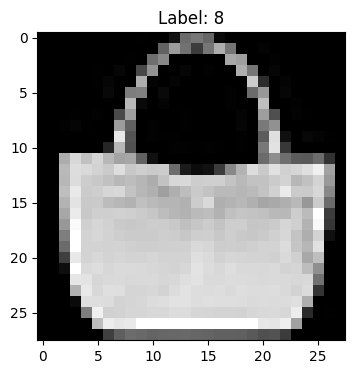

In [6]:
# TODO : Plot the image in the sample. Does it correspond to the second element of the sample ?


image, label = sample

plt.figure(figsize=(10, 4))
plt.imshow(image, cmap='gray')  # Adjust the colormap as needed
plt.title(f"Label: {label}")
plt.show()

In [7]:
# TODO : What's the shape of the input image.
shape = image.size
print("Image Shape:", shape)

Image Shape: (28, 28)


### Data distribution

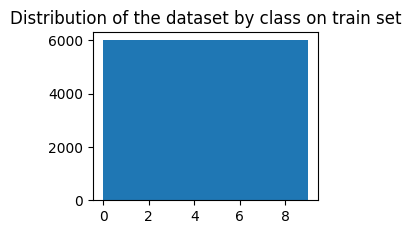

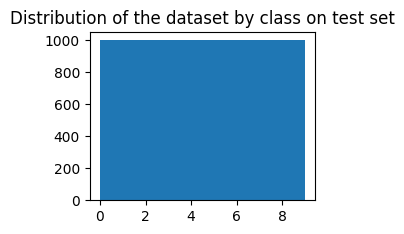

(<Axes: title={'center': 'Distribution of the dataset by class on test set'}>,
 None)

In [8]:
#Lets plot the distribution of the dataset by class:

def plot_bar(dataset, type='train'):
    labels = []
    for i in range(len(dataset)):
        labels.append(dataset[i][1])
    plt.hist(labels, bins=10)
    plt.title("Distribution of the dataset by class on " + type + " set" )
    plt.show()


plt.subplot(221), plot_bar(dataset_train)
plt.subplot(222), plot_bar(dataset_test, "test")

### Label mapping

Here we can see the Label Mapping of the FahsionMNIST Dataset
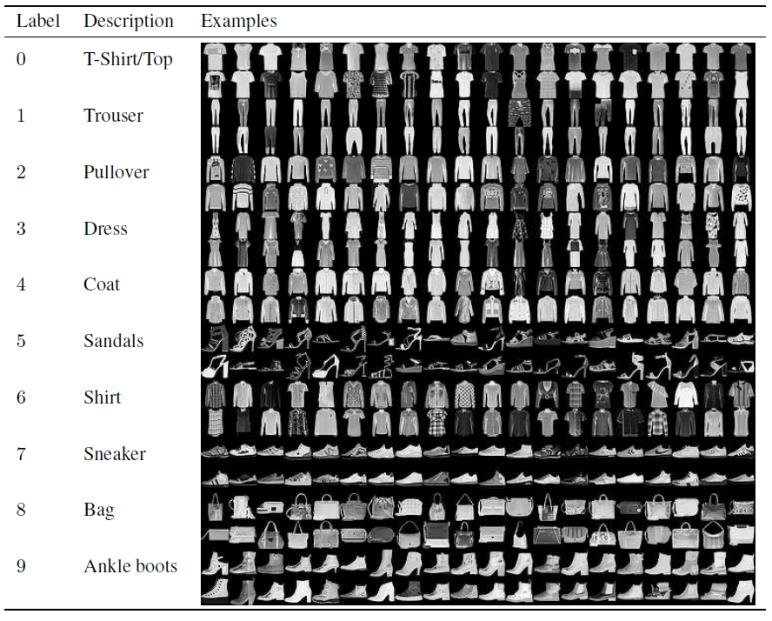


In [10]:
import torch
import torchvision.models as models

# Load a pre-trained GoogLeNet model
model = models.googlenet(pretrained=True)
num_classes = 10  # Number of classes in Fashion MNIST
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 165MB/s]


In [14]:
batch_size_train, batch_size_valid, batch_size_test = 32,32,32
data_dir = ''
transform1 = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert to RGB
    transforms.ToTensor(),  # Convert to a PyTorch tensor
])

mnist_dataset = FashionMNIST(data_dir, train= True, transform=transform1)
train_size = int(0.8 * len(mnist_dataset))
test_size = len(dataset_train) - train_size
mnist_train, mnist_valid =  torch.utils.data.random_split(mnist_dataset, [train_size, test_size])
mnist_test = FashionMNIST(data_dir, train=False, transform=transform1)

train_loader = DataLoader(mnist_train, batch_size=batch_size_train, shuffle=True)
val_loader = DataLoader(mnist_valid, batch_size=batch_size_valid, shuffle = True)
test_loader = DataLoader(mnist_test, batch_size=batch_size_test)


In [16]:
import torch.optim as optim
from tqdm import tqdm  # Import tqdm for the progress bar

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

num_epochs = 10  # Number of training epochs
for epoch in range(num_epochs):
    model.train()

    # Create a progress bar for the training loop
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', ncols=100)

    for inputs, labels in progress_bar:  # Load data using a DataLoader
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Update the progress bar description with the current loss
        progress_bar.set_postfix(loss=loss.item())

    # Close the progress bar after the epoch is complete
    progress_bar.close()


Epoch 10/10: 100%|█████████████████████████████████| 1500/1500 [05:36<00:00,  4.46it/s, loss=0.0822]


In [17]:
model.eval()  # Set the model to evaluation mode (important for dropout and batch normalization)

correct = 0
total = 0

# Disable gradient calculation during validation
with torch.no_grad():
    for inputs, labels in val_loader:  # Replace 'validation_loader' with your validation data loader
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Validation Accuracy: {accuracy:.2f}%')


Validation Accuracy: 92.28%


In [18]:
model.eval()  # Set the model to evaluation mode (important for dropout and batch normalization)

correct = 0
total = 0

# Disable gradient calculation during testing
with torch.no_grad():
    for inputs, labels in test_loader:  # Replace 'test_loader' with your test data loader
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')


Test Accuracy: 92.06%


In [19]:
torch.save(model.state_dict(), 'googlenet_fashion_mnist.pth')


#### Testing the model on a random image

In [44]:
import torch
import torchvision.models as models


state_dict = torch.load('googlenet_fashion_mnist.pth')
# Remove auxiliary classifier keys from the state_dict
state_dict.pop('aux1.conv.conv.weight', None)
state_dict.pop('aux1.conv.bn.weight', None)
state_dict.pop('aux1.conv.bn.bias', None)
state_dict.pop('aux1.fc1.weight', None)
# ... Repeat for other auxiliary classifier keys

# Load the fine-tuned model

model = models.googlenet(pretrained=False)  # Initialize a new model
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)  # Adjust num_classes
# Load the state_dict into your model
model.load_state_dict(state_dict, strict=False)




# model.load_state_dict(torch.load('/content/googlenet_fashion_mnist.pth'))
model.eval()  # Set the model to evaluation mode


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/googlenet.py:47: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [45]:
from PIL import Image
import numpy as np

def preprocess_image(image_path):
    image = Image.open(image_path)
    image = image.resize((299, 299))  # Resize to GoogLeNet input size
    image = image.convert('RGB')  # Convert to RGB if needed
    image = np.array(image)
    image = image / 255.0  # Normalize pixel values to [0, 1]
    return image


In [48]:
image_path = '/content/151761.01.05-03-580.jpg'  # Replace with the path to your image
image = preprocess_image(image_path)
image = torch.tensor(image, dtype=torch.float32)  # Convert to a PyTorch tensor
image = image.permute(2, 0, 1)  # Adjust the dimensions

# Forward pass through the model
with torch.no_grad():
    output = model(image.unsqueeze(0))  # Add a batch dimension

# Get the predicted class label (or class probabilities)
_, predicted = torch.max(output, 1)  # For classification


In [51]:
class_names = ["Tee", "trouser", "Pullover", "Dress", "Coat", "Sandals", "Shirt", "Sneaker", "Bag", "Ankle boot"]  # Replace with your class names
predicted_class_name = class_names[predicted.item()]
predicted_class_name


'trouser'